# XGBoostを使用してみる

## 参考資料
* https://qiita.com/predora005/items/19aebcf3aa05946c7cf4
* https://qiita.com/automation2025/items/6f0d6ff4abe106a2dd89
* https://xgboost.readthedocs.io/en/latest/install.html

### インストール

私の環境では`-cpu`をつけないと`import`の時にエラーが出てしまい、インポートできなかった。
MacBook Air(2022 M2), OS : Sonama 14.2.1

In [2]:
! pip install xgboost-cpu

### インポート

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

### データの準備

In [4]:
train = pd.read_csv("../data/input/train.csv")
test = pd.read_csv("../data/input/test.csv")
submission = pd.read_csv("../data/input/sample_submission.csv")

`LabelEncoder()`を用いて文字列をアルファベット順に番号づけする。

In [5]:
le_personality = LabelEncoder()
le = LabelEncoder()
train["Personality_encoded"] = le_personality.fit_transform(train["Personality"])

カテゴリカルな特徴量を数値に変換する。

In [6]:
categorical_cols = train.select_dtypes(exclude=['number']).columns

for col in categorical_cols:
    train[col] = le.fit_transform(train[col])

`drop`を使用して`id`から`Personality`を除いたデータフレームを作成

In [7]:
X = train.drop(columns=["id", "Personality", "Personality_encoded"])
y = train["Personality_encoded"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

# 低レベルPython APIを使用する場合

学習する際に書くコード自体は簡単であるが、学習後の解析の容易さの点では`scikitlearn`を使用した方が良いと思う。

### XGBoost用の型`DMatrix`に変換する

In [9]:
print(X_train.dtypes)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

Time_spent_Alone             float64
Stage_fear                     int64
Social_event_attendance      float64
Going_outside                float64
Drained_after_socializing      int64
Friends_circle_size          float64
Post_frequency               float64
dtype: object


### パラメータの設定

公式Documentが参考になる。今回はパラメータの設定方法の勉強としてソフトマックス関数を使用し、分類するクラスは2にする。 <br>
公式Document : https://xgboost.readthedocs.io/en/latest/parameter.html

In [10]:
params = {
    'objective': 'multi:softmax',  # ソフトマックス関数を使用
    'num_class': 2,  # 分類するクラス数
}

evals_result = {}
watchlist = [(dtrain, 'train'), (dtest, 'test')]

`evel_result`を設定することで学習曲線の可視化が可能になる

### 学習と予測

In [11]:
bst = xgb.train(
    params,
    dtrain,
    evals=watchlist,
    evals_result=evals_result,
    num_boost_round=100,
    verbose_eval=False
    )
y_pred = bst.predict(dtest)

### 結果の確認

In [12]:
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {score:.4f}')

Accuracy: 0.9636


### どの特徴量が予測結果に寄与したか確認

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

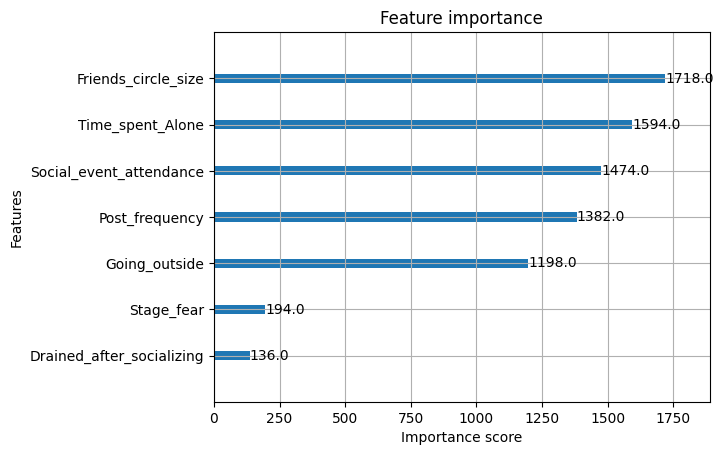

In [13]:
xgb.plot_importance(bst)

### 個々の決定木の可視化

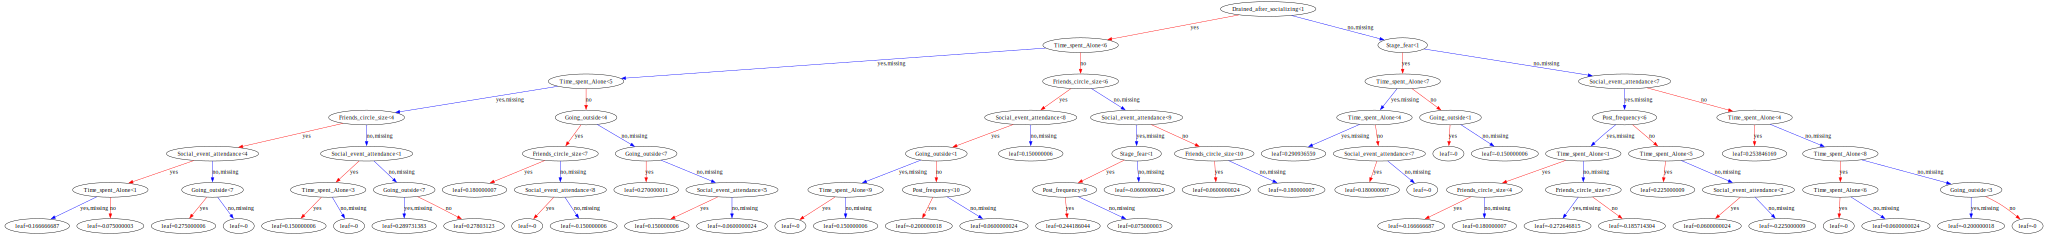

In [14]:
from IPython.display import SVG, display

gv = xgb.to_graphviz(bst, tree_idx=0)
gv.format = 'svg'
display(SVG(gv.pipe(format='svg')))

### 学習曲線の可視化

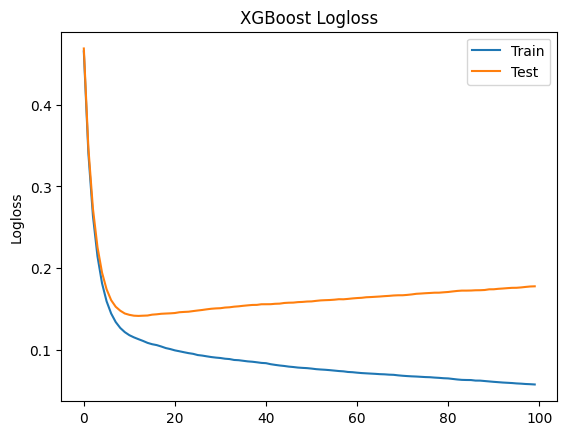

In [15]:
epochs = len(evals_result['train']['mlogloss'])
x_axis = range(epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, evals_result['train']['mlogloss'], label='Train')
ax.plot(x_axis, evals_result['test']['mlogloss'],  label='Test')
ax.legend()
plt.ylabel('Logloss')
plt.title('XGBoost Logloss')
plt.show()

学習時に設定した`eval_result`を使用して学習曲線を可視化した。 <br>
今回は`num_boost_round`を100としたこともあり、過学習している。 <br>
なのでCVスコアを出力する。

In [16]:
cv_results = xgb.cv(
    params,
    dtrain
)

print(f"CV Accuracy: {cv_results['test-mlogloss-mean'].min():.4f} ± {cv_results['test-mlogloss-std'].min():.4f}")

CV Accuracy: 0.1336 ± 0.0006


# `scikitlearn`ラッパーの使用

### モデルの作成

In [17]:
model = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    objective='binary:logistic',
    eval_metric='error',
)

### モデルの学習

In [18]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
    )

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'error'


### 予測と精度

In [19]:
y_pred_scikit = model.predict(X_test)
score_scikit = accuracy_score(y_test, y_pred_scikit)
print(f'Scikit-learn Accuracy: {score_scikit:.4f}')

Scikit-learn Accuracy: 0.9646


### 重要な特徴量の可視化

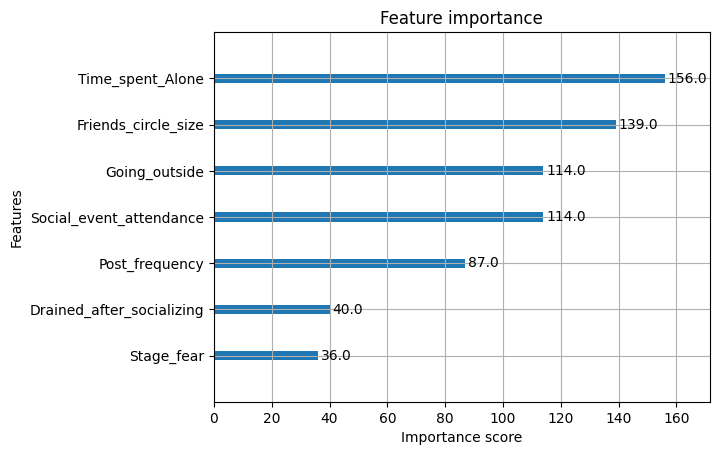

In [20]:
xgb.plot_importance(model)
plt.show()

### 学習曲線の可視化

`validation_0, validation_1`はそれぞれ訓練データ、テストデータを表す。

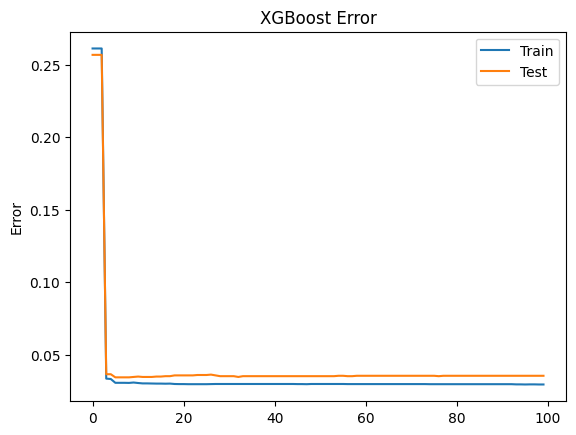

In [21]:
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Error')
plt.title('XGBoost Error')
plt.show()

### CVスコア

In [22]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X, y)
print(f'Scikit-learn CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

Scikit-learn CV Accuracy: 0.9690 ± 0.0034


### ハイパーパラメータチューニング

グリッドサーチを用いてより良いハイパーパラメータを決定する。

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
}
grid_search = GridSearchCV(model, param_grid)
grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_:.4f}')


Best parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}
Best cross-validation score: 0.9701


### 予測結果の可視化

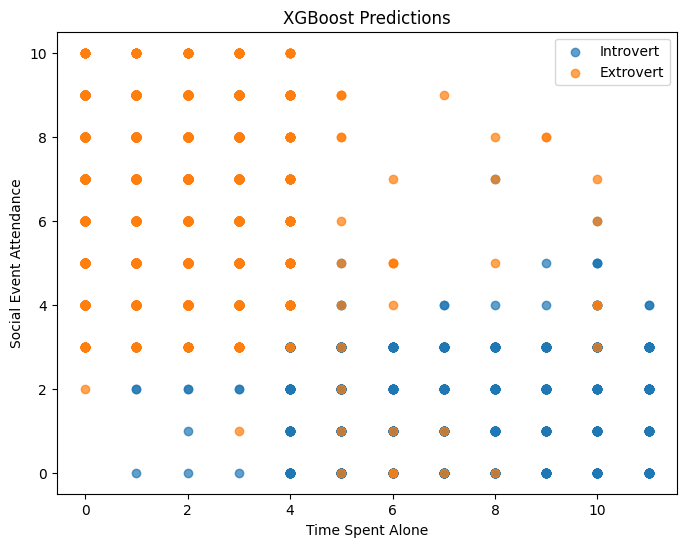

In [24]:
introverts = (y_pred == 1)
extroverts = (y_pred == 0)

plt.figure(figsize=(8,6))
# Introvert
plt.scatter(
    X_test.loc[introverts, 'Time_spent_Alone'],
    X_test.loc[introverts, 'Social_event_attendance'],
    label='Introvert',
    alpha=0.7
)
# Extrovert
plt.scatter(
    X_test.loc[extroverts, 'Time_spent_Alone'],
    X_test.loc[extroverts, 'Social_event_attendance'],
    label='Extrovert',
    alpha=0.7
)

plt.xlabel('Time Spent Alone')
plt.ylabel('Social Event Attendance')
plt.title('XGBoost Predictions')
plt.legend()
plt.show()


# テストデータを用いて予測、提出

### テストデータの予測

In [25]:
categorical_cols = test.select_dtypes(exclude=['number']).columns

for col in categorical_cols:
    test[col] = le.fit_transform(test[col])

test_predictions = grid_search.predict(test.drop(columns=["id"]))
final_predictions = np.array(test_predictions).astype(int)

In [26]:
submission["Personality"] = le_personality.inverse_transform(final_predictions)
submission.head()

,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert


### 提出

In [27]:
submission.to_csv("../data/output/submission_xgboost.csv", index=False)
print("Submission saved to ../data/output/submission_xgboost.csv")

Submission saved to ../data/output/submission_xgboost.csv


In [29]:
!kaggle competitions submit -c playground-series-s5e7 -f ../data/output/submission_xgboost.csv -m "XGBoost"

100%|██████████████████████████████████████| 96.5k/96.5k [00:01<00:00, 96.4kB/s]
Successfully submitted to Predict the Introverts from the Extroverts